## Import

In [1]:
import numpy as np
import pandas as pd
from google.cloud import bigquery

import importlib
import my_functions as utils

from matplotlib import pyplot as plt
import seaborn as sns
import sweetviz as sv

from sklearn import metrics as mt
import sklearn.model_selection as ms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

importlib.reload(utils)

/home/arthur/projetos/Case-O-Boticario/case-boticario/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/arthur/projetos/Case-O-Boticario/case-boticario/lib/python3.12/site-packages/sweetviz/graph.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


<module 'my_functions' from '/home/arthur/projetos/Case-O-Boticario/notebooks/my_functions.py'>

## Variáveis

In [2]:
PROJETO = 'case-o-boticario-467017' ## projeto_bq
TARGET = 'risco'                    ## nome variável resposta
sns.set_palette('dark')             ## Definindo paleta de cores

## Carregando Dados

In [3]:
# # carregando dados do BQ
# df = utils.load_data_bigquery(projeto=PROJETO,query="SELECT * FROM dados.bd_niveis_de_risco_por_produto")

# # salvando localmente
# utils.save_parquet_file(file=df, name='../data/niveis_de_risco_por_produto')

## carregando arquivo temporário
df = utils.load_parquet_file(name='../data/niveis_de_risco_por_produto')

df.head()

,cod_projeto,des_nome_projeto,des_validade_projeto,des_marca,des_submarca,des_categoria_ped,des_subcategoria,des_embalagem,des_base_estrutura,des_fragrancia_cor,des_ciclo_vida_projeto,cod_produto,des_material,des_validade_material,ano_ciclo_previsto,vlr_temperatura,des_temperatura
0,1a2fb34e,1,ATIVO,1,1,1,1,2,9,11,ABERTO,c9411b75,4581,ATIVO,2026-07-01 00:00:00,None,0. DESCONHECIDO
1,1a2fb34e,1,ATIVO,1,1,1,1,9,9,11,ABERTO,794c18f8,3597,ATIVO,2026-02-01 00:00:00,5,4. RISCO_ALTO
2,1a2fb34e,1,ATIVO,1,1,1,1,1,1,1,ABERTO,e23454e6,4579,ATIVO,2026-07-01 00:00:00,None,0. DESCONHECIDO
3,1a2fb34e,1,ATIVO,1,1,1,1,2,9,11,ABERTO,f6186094,4559,ATIVO,2026-09-01 00:00:00,None,0. DESCONHECIDO
4,1a2fb34e,1,ATIVO,1,1,1,1,1,1,1,ABERTO,ec8e36ac,1,ATIVO,None,None,0. DESCONHECIDO


In [4]:
df.isna().sum()

cod_projeto                  0
des_nome_projeto             0
des_validade_projeto         0
des_marca                    0
des_submarca                 0
des_categoria_ped            0
des_subcategoria             0
des_embalagem                0
des_base_estrutura           0
des_fragrancia_cor           0
des_ciclo_vida_projeto       0
cod_produto                  0
des_material                 0
des_validade_material        0
ano_ciclo_previsto          80
vlr_temperatura           4124
des_temperatura              0
dtype: int64

In [5]:
df.groupby(['des_ciclo_vida_projeto', 'des_temperatura']).agg(total=('cod_produto', 'nunique'))

total
des_ciclo_vida_projeto des_temperatura            
ABERTO                 0. DESCONHECIDO        3569
                       1. SEM_RISCO            825
                       2. BAIXO_RISCO          177
                       3. RISCO_MODERADO       322
                       4. RISCO_ALTO           165
                       5. IMPACTO_PROJETADO      8
NÃO INICIADO           0. DESCONHECIDO         493
PRÉ CONTROLE           0. DESCONHECIDO          69

## Desenvolvimento

### **1. Entendimento do Negócio**

**Objetivo**: Compreender o contexto do problema, os objetivos da organização e como o projeto de dados pode ajudar a alcançá-los.

Atividades esperadas:
- Formular o problema de negócio em uma pergunta clara de dados.
- Identificar objetivos estratégicos e operacionais do projeto.
- Mapear stakeholders e suas expectativas.
- Usar filtro des_ciclo_vida_projeto = ABERTO.

### **2. Entendimento dos Dados**
**Objetivo**: Coletar dados relevantes, compreender sua estrutura, qualidade e limitações.

Atividades esperadas:
- Exploração inicial do dataset: tipos de variáveis, volumes, ausência de dados.
- Análise descritiva: médias, desvios, distribuição de valores.
- Identificação de outliers ou padrões sazonais.
- Usar filtro des_ciclo_vida_projeto = ABERTO.

#### Separação dados de treino, produção

- dados_modelo: dados rotulados utilizados para o treino e validação do modelo
- dados_producao: dados não rotulados

In [6]:
dados = df.copy()
dados_modelo = df.loc[(df['des_ciclo_vida_projeto'] == 'ABERTO')].copy()
dados_producao = df.loc[(df['des_ciclo_vida_projeto'] == 'NÃO INICIADO') | (df['des_ciclo_vida_projeto'] == 'PRÉ CONTROLE')].copy()

#### Análise Descritiva

In [7]:
## separação dos dados numéricos e categóricos

numerical_atributes = dados_modelo.select_dtypes(include=['int64'])
categorical_atributes = dados_modelo.select_dtypes(exclude=['int64'])

##### Numéricos

In [8]:
df_uniques = numerical_atributes.describe().T.reset_index().rename(columns={'index':'column_name'})
df_types = pd.DataFrame(data=numerical_atributes.dtypes).reset_index().rename(columns={'index':'column_name',0:'type'})
df_null = pd.DataFrame(numerical_atributes.isna().sum()).reset_index().rename(columns={'index':'column_name',0:'null_values'})

df_describe = pd.merge(df_uniques, df_types, on='column_name', how='left')
df_describe = pd.merge(df_describe, df_null, on='column_name', how='left')
df_describe.round(0)

,column_name,count,mean,std,min,25%,50%,75%,max,type,null_values
0,des_nome_projeto,5066.0,251.0,172.0,1.0,94.0,247.0,401.0,627.0,int64,0
1,des_marca,5066.0,3.0,2.0,1.0,2.0,2.0,2.0,13.0,int64,0
2,des_submarca,5066.0,15.0,13.0,1.0,7.0,10.0,18.0,69.0,int64,0
3,des_categoria_ped,5066.0,4.0,2.0,1.0,3.0,4.0,5.0,11.0,int64,0
4,des_subcategoria,5066.0,13.0,7.0,1.0,8.0,12.0,18.0,41.0,int64,0
5,des_embalagem,5066.0,6.0,6.0,1.0,1.0,5.0,10.0,27.0,int64,0
6,des_base_estrutura,5066.0,4.0,3.0,1.0,1.0,3.0,6.0,12.0,int64,0
7,des_fragrancia_cor,5066.0,5.0,3.0,1.0,3.0,4.0,7.0,14.0,int64,0
8,des_material,5066.0,3719.0,2303.0,1.0,1774.0,3575.0,5624.0,8305.0,int64,0


##### Categóricos

In [9]:
df_uniques = categorical_atributes.describe().T.reset_index().rename(columns={'index':'column_name'})
df_types = pd.DataFrame(data=categorical_atributes.dtypes).reset_index().rename(columns={'index':'column_name',0:'type'})
df_null = pd.DataFrame(categorical_atributes.isna().sum()).reset_index().rename(columns={'index':'column_name',0:'null_values'})

df_describe = pd.merge(df_uniques, df_types, on='column_name', how='left')
df_describe = pd.merge(df_describe, df_null, on='column_name', how='left')
df_describe.drop(columns={'top', 'freq'})

,column_name,count,unique,type,null_values
0,cod_projeto,5066,490,object,0
1,des_validade_projeto,5066,1,object,0
2,des_ciclo_vida_projeto,5066,1,object,0
3,cod_produto,5066,5066,object,0
4,des_validade_material,5066,1,object,0
5,ano_ciclo_previsto,4987,71,object,79
6,vlr_temperatura,1504,6,object,3562
7,des_temperatura,5066,6,object,0


### **3. Preparação dos Dados**
Objetivo: Limpar, transformar e formatar os dados para uso em modelos analíticos.

Atividades esperadas:
- Tratamento de dados ausentes e valores extremos.
- Engenharia de atributos (ex: criação de faixas, categorias, variáveis dummies).
- Filtragem por colunas relevantes ou criação de colunas derivadas.
- Usar filtro des_ciclo_vida_projeto = ABERTO.


#### **Tratamento de Valores Nulos**

- Os produtos que possuem vlr_temperatura nulo são os produtos com risco desconhecido pelo gestor
- Como não temos o valor do risco para esses produtos e não é possível inferi-los, eles serão removidos

In [ ]:
dados_modelo = dados_modelo.dropna(subset=['vlr_temperatura'])
dados_modelo = dados_modelo.dropna(subset=['ano_ciclo_previsto'])
dados_modelo.shape

(1504, 17)

#### **Engenharia de Atributos**

##### Criação de Features

In [ ]:
## Definindo variável resposta
dados_modelo['risco'] = dados_modelo['des_temperatura'].apply(lambda x: 0 if x in ['1. SEM_RISCO'] else 1 )

##### Preparação de Features

- Aqui é definido um dicionário com a transformação desejada para cada variável. A transformação será feita nas etapas à seguir.
- As possibilidades de transformação são:

  - Target Encode
  - Frequency Encode
  - None 

In [306]:
dict_preparation = {
    'cod_projeto':None,
    'des_nome_projeto':None,
    'des_validade_projeto':None,
    'des_marca':'frequency_encode',
    'des_submarca':'frequency_encode',
    'des_categoria_ped':'frequency_encode',
    'des_subcategoria':'frequency_encode',
    'des_embalagem':'frequency_encode',
    'des_base_estrutura':'frequency_encode',
    'des_fragrancia_cor':'freqfrequency_encodeuency',
    'des_ciclo_vida_projeto':'frequency_encode',
    'cod_produto':None,
    'des_material':'frequency_encode',
    'des_validade_material':None,
    'ano_ciclo_previsto':None,
    'vlr_temperatura':None,
    'des_temperatura':None
}

### Filtragem do Dataset

- Os filtros necessários já foram realizados anteriormente mas são reforçados aqui

In [307]:
dados_modelo = dados_modelo.loc[dados_modelo['des_validade_material'] == 'ATIVO']
dados_modelo = dados_modelo.loc[dados_modelo['des_ciclo_vida_projeto'] == 'ABERTO']
dados_modelo.shape

(1504, 20)

### **4. Modelagem**
Objetivo: Aplicar técnicas estatísticas ou de machine learning para gerar previsões ou classificações.

Atividades esperadas:
- Escolha de modelo (ex: regressão linear, árvore de decisão, etc).
- Definição de variáveis preditoras e variável-alvo.
- Ajuste de parâmetros e validação cruzada.
- Usar filtro des_ciclo_vida_projeto = ABERTO.

#### Escolha dos Modelos

In [164]:
## Modelos que serão avaliados
modelos = {
    'Regressão Logística': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'KNN': KNeighborsClassifier()
}

#### Seleção de Atributos

In [165]:
## colunas que serão removidas
columns_to_drop = [
    # colunas referentes ao projeto
    'cod_projeto',
    'des_nome_projeto',
    'des_validade_projeto',

    # identificador do produto
    'cod_produto',

    # variáveis sem valor preditivo
    'des_ciclo_vida_projeto',
    'des_validade_material', 

    # variáveis redundantes
    'vlr_temperatura', # redundantes em relação a variável resposta
    'des_temperatura', # redundantes em relação a variável resposta

    # não utilizada neste momento
    'ano_ciclo_previsto',

    # variável resposta
    'risco'
]

features_selected = [column for column in dados_modelo.columns.tolist() if column not in columns_to_drop]

##### Importancia das Features

- Calculando importancia das features com o modelo Random Forest

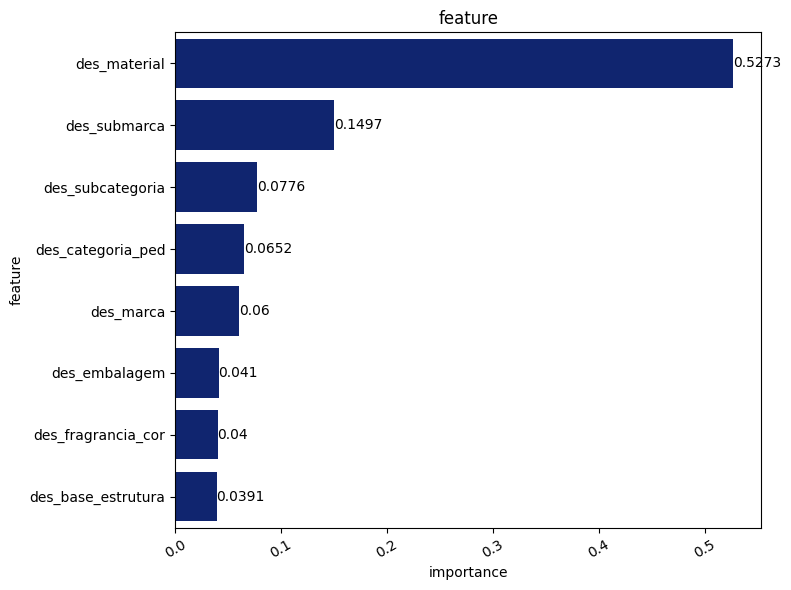

In [166]:
# Seletor de Features
model = RandomForestClassifier()

model.fit(dados_modelo[features_selected], dados_modelo['risco'])
importances = model.feature_importances_

# Plot
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_names = np.asarray(features_selected)


# Lista de nomes ordenados
ordered_feature_names = [feature_names[i] for i in indices]
colors = ['orange' if f in features_selected else 'steelblue' for f in ordered_feature_names]

features_importances = pd.DataFrame([feature_names[indices], importances[indices]]).T.rename(columns={0: 'feature', 1:'importance'})
features_importances['importance'] = features_importances['importance'].apply(lambda x: round(x, 4))

utils.plot_matrix(
    data=features_importances,
    columns_features=['feature'],
    plot=sns.barplot,
    loop_feature='y',
    sort_by='importance',
    n_rows=1,
    n_cols=1,
    figsize=(8, 6),
    plot_kwargs={'x':'importance'}
)

#### Ajuste de Hiperparâmetros

- Neste primeiro ciclo não será realizado ajuste de hiperparametros

### **5. Avaliação**
Objetivo: Validar os resultados dos modelos e avaliar se atendem ao objetivo de negócio.

Atividades esperadas:
- Métricas de desempenho (MAPE, RMSE, R² etc.).
- Comparação com benchmarks históricos.
- Validação qualitativa com base no contexto de negócio.
- Usar filtro des_ciclo_vida_projeto = ABERTO.


In [168]:
# Parâmetros
n_splits = 5
k_folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# armazena métricas dos modelos
df_results = pd.DataFrame()

# para cada modelo
for nome_modelo in modelos.keys():
    
    modelo = modelos[nome_modelo]

    df_aux = utils.cross_validation(k_folds, modelo, nome_modelo, dados_modelo, dict_preparation, features_selected, TARGET)

    df_results = pd.concat([df_results, df_aux], axis=0)

df_results


/home/arthur/projetos/Case-O-Boticario/case-boticario/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model Name,Accuracy,Precision,Recall,F1-Score
0,Regressão Logística,0.573803,0.553848,0.329880,0.412307
0,Random Forest,0.863043,0.860614,0.832124,0.844597
0,XGBoost,0.863043,0.859384,0.833584,0.844529
0,KNN,0.797872,0.775788,0.776155,0.775769


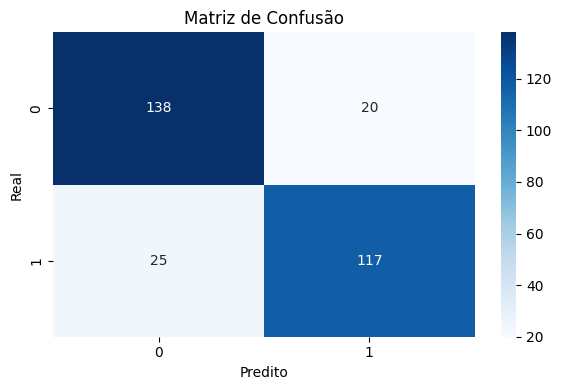

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels=None, title='Matriz de Confusão'):
    cm = mt.confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predito')
    plt.ylabel('Real') 
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_validacao, y_pred, labels=[0,1], title='Matriz de Confusão')

### **6. Implementação do Modelo**
Objetivo: Preparar a entrega do modelo/solução e demonstrar como ele pode ser utilizado.

Atividades esperadas:
- Entrega de dashboard, código ou relatório explicativo.
- Sugestão de como integrar o modelo no processo de decisão da empresa.
- Proposta de melhorias contínuas (ex: atualização mensal do modelo).
- Usar filtro des_ciclo_vida_projeto = NÃO INICIADO e PRÉ-CONTROLE.


In [ ]:
best_model_name = 'XGBoost'
best_params = {}

utils.save_picked_file(file=modelos[best_model_name], name=f'../models/ciclo1-best_model-{best_model_name}')

['../models/ciclo1-best_model-XGBoost.pkl']

In [ ]:
## preparando dados
dados_producao_transformed = utils.preparacao_dos_dados(dados_producao, dict_preparation, False)

## selecionando features
X_prod = dados_producao_transformed[features_selected]

## fazendo predição
modelo = utils.load_picked_file(name=f'../models/ciclo1_modelo_{best_model_name}')
y_hat = modelo.predict(X_prod)
dados_producao['estimativa_risco'] = y_hat